In [1]:
%store -r sheyenne_grasslands_gdf caddo_grasslands_gdf data_dir

In [2]:
# Import necessary packages
import os
import pathlib
from math import floor, ceil

from glob import glob
import pandas as pd # Aggregating and data manipulation
import matplotlib.pyplot as plt # Overlay pandas and xarray plots
import rioxarray as rxr # Work with raster data
from rioxarray.merge import merge_arrays # Merge rasters

## Load in soil data

For each grassland, download at least one soil variable from the [POLARIS dataset](http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/) as raster data. 
    
* [Further POLARIS info](https://pubs.usgs.gov/publication/70170912)

* I'll look at soil pH, specifically the mean soil pH of 30x30 meter pieces of land for the 60-100 cm depth. *S. nutans* prefers a soil pH of [4.8 to 8.0](https://www.nrcs.usda.gov/plantmaterials/etpmcpg13196.pdf) and has a minimum [root depth of 24 inches, or about 61 cm](https://plants.sc.egov.usda.gov/plant-profile/SONU2/characteristics).

* Depths of the POLARIS data set is in cm.

* Need to use rioxarray to import

### Load in Sheyenne soil data

In [3]:
# Define data directory for the Sheyenne soil data
sheyenne_soil_dir = os.path.join(data_dir, 'sheyenne-soil-ph')

os.makedirs(sheyenne_soil_dir, exist_ok=True)

sheyenne_soil_pattern = os.path.join (sheyenne_soil_dir, '*.tif')
sheyenne_soil_pattern

'C:\\Users\\riede\\earth-analytics\\data\\habitat-suitability\\sheyenne-soil-ph\\*.tif'

array([-97.46881033,  46.09534316, -96.93854828,  46.57204154])

'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat4647_lon{min_lon}{max_lon}.tif'

Path: C:\Users\riede\earth-analytics\data\habitat-suitability\sheyenne-soil-ph\soil_lat4647_lon-98_-97.tif
file already exists: C:\Users\riede\earth-analytics\data\habitat-suitability\sheyenne-soil-ph\soil_lat4647_lon-98_-97.tif
OPENED
CROPPED
Path: C:\Users\riede\earth-analytics\data\habitat-suitability\sheyenne-soil-ph\soil_lat4647_lon-97_-96.tif
file already exists: C:\Users\riede\earth-analytics\data\habitat-suitability\sheyenne-soil-ph\soil_lat4647_lon-97_-96.tif
OPENED
CROPPED


[<xarray.DataArray (y: 1717, x: 1688)> Size: 12MB
 [2898296 values with dtype=float32]
 Coordinates:
     band         int64 8B 1
   * x            (x) float64 14kB -97.47 -97.47 -97.47 ... -97.0 -97.0 -97.0
   * y            (y) float64 14kB 46.57 46.57 46.57 46.57 ... 46.1 46.1 46.1
     spatial_ref  int64 8B 0
 Attributes:
     AREA_OR_POINT:  Area,
 <xarray.DataArray (y: 1717, x: 222)> Size: 2MB
 [381174 values with dtype=float32]
 Coordinates:
     band         int64 8B 1
   * x            (x) float64 2kB -97.0 -97.0 -97.0 ... -96.94 -96.94 -96.94
   * y            (y) float64 14kB 46.57 46.57 46.57 46.57 ... 46.1 46.1 46.1
     spatial_ref  int64 8B 0
 Attributes:
     AREA_OR_POINT:  Area]

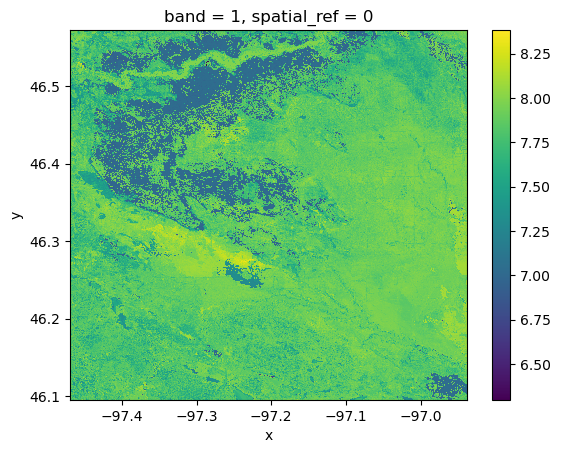

In [4]:
# Define Sheyenne bounds
sheyenne_bounds = s_bounds_min_lon, s_bounds_min_lat, s_bounds_max_lon, s_bounds_max_lat = (
    sheyenne_grasslands_gdf
    #.to_crs(ccrs.UTM(zone=14))
    .total_bounds)
display(sheyenne_bounds)

#  Define the sheyenne download URL template for the soil data
sheyenne_soil_template_url = ("http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/"
            "v1.0"
            "/ph"
            "/mean"
            "/60_100"
            "/lat4647_lon{min_lon}{max_lon}.tif")
display(sheyenne_soil_template_url)

# List out all the Sheyenne soil files we will need to download
sheyenne_das = []
for min_lon in range(floor(s_bounds_min_lon), ceil(s_bounds_max_lon)):
    for min_lat in range(floor(s_bounds_min_lat), ceil(s_bounds_max_lat)):
        max_lon = min_lon + 1
        soil_url = sheyenne_soil_template_url.format(
            min_lon=min_lon,
            max_lon=max_lon)
         # Define the file path for saving the downloaded raster data
        soil_path = os.path.join(sheyenne_soil_dir, f"soil_lat4647_lon{min_lon}_{max_lon}.tif")
        print(f"Path: {soil_path}")

        if not os.path.exists(soil_path):
            # Load the raster data into Python, mask and scale and squeeze w/ .tif files
            soil_da = rxr.open_rasterio(
                soil_url,
                mask_and_scale=True
                ).squeeze()
            soil_da.to_netcdf(soil_path)
        else:
            print(f'file already exists: {soil_path}')
            print('OPENED')

        # Open and squeeze data set
        soil_da = rxr.open_rasterio(
            soil_url,
            mask_and_scale=True
        ).squeeze()

        # Crop the raster data
        cropped_da = soil_da.rio.clip_box(*sheyenne_bounds)
        sheyenne_das.append(cropped_da)
        print('CROPPED')

display(sheyenne_das)

# Merge tiles
sheyenne_merged_das = merge_arrays(sheyenne_das)
sheyenne_merged_das.plot()

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

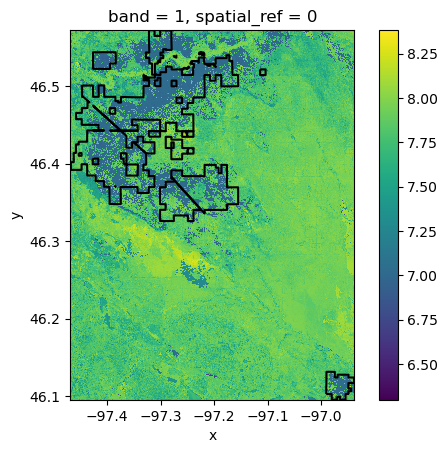

In [5]:
sheyenne_merged_das.plot()

# Plot Sheyenne National Grasslands on sheyenne_soil_da
sheyenne_grasslands_gdf.to_crs(sheyenne_merged_das.rio.crs).boundary.plot(ax = plt.gca(), color='black')

### Load Caddo soil data

array([-96.16923458,  33.38543577, -95.85492674,  33.80186199])

'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat3334_lon{min_lon}{max_lon}.tif'

['http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat3334_lon-97-96.tif',
 'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat3334_lon-96-95.tif']

OPENED
CROPPED
OPENED
CROPPED


[<xarray.DataArray (y: 1500, x: 610)> Size: 4MB
 [915000 values with dtype=float32]
 Coordinates:
     band         int64 8B 1
   * x            (x) float64 5kB -96.17 -96.17 -96.17 ... -96.0 -96.0 -96.0
   * y            (y) float64 12kB 33.8 33.8 33.8 33.8 ... 33.39 33.39 33.39
     spatial_ref  int64 8B 0
 Attributes:
     AREA_OR_POINT:  Area,
 <xarray.DataArray (y: 1500, x: 523)> Size: 3MB
 [784500 values with dtype=float32]
 Coordinates:
     band         int64 8B 1
   * x            (x) float64 4kB -96.0 -96.0 -96.0 ... -95.86 -95.86 -95.85
   * y            (y) float64 12kB 33.8 33.8 33.8 33.8 ... 33.39 33.39 33.39
     spatial_ref  int64 8B 0
 Attributes:
     AREA_OR_POINT:  Area]

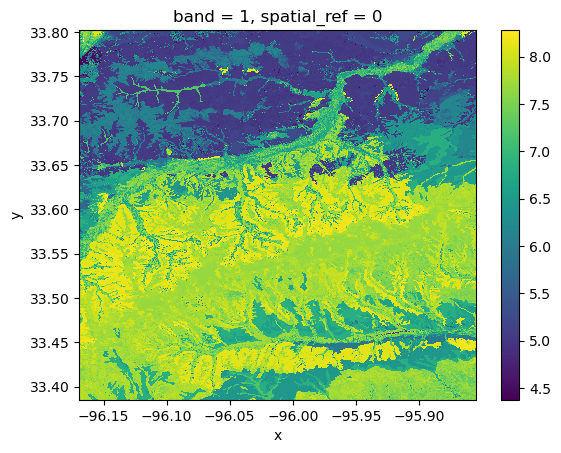

In [5]:
# Define Caddo bounds
caddo_bounds = c_bounds_min_lon, c_bounds_min_lat, c_bounds_max_lon, c_bounds_max_lat = (
    caddo_grasslands_gdf
    #.to_crs(ccrs.UTM(zone=14))
    .total_bounds)
display(caddo_bounds)

#  Define the Caddo download URL template for the soil data
caddo_soil_template_url = ("http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/"
            "v1.0"
            "/ph"
            "/mean"
            "/60_100"
            "/lat3334_lon{min_lon}{max_lon}.tif")
display(caddo_soil_template_url)

# List out all the Caddo soil files we will need to download
caddo_soil_url_list = []
for min_lon in range(floor(c_bounds_min_lon), ceil(c_bounds_max_lon)):
    for min_lat in range(floor(c_bounds_min_lat), ceil(c_bounds_max_lat)):
        soil_url = caddo_soil_template_url.format(
            min_lon=min_lon, max_lon=min_lon+1)
        caddo_soil_url_list.append(soil_url)
display(caddo_soil_url_list)

caddo_das = []
# Loop through each of the soil files
for i in caddo_soil_url_list:
    # Download raster data

    # Unzip the raster data

    # Extract metadata from the file name

    # Only download once -- Save raster data to the disk

    # Load the raster data into Python, mask and scale and squeeze w/ .tif files
    soil_da = rxr.open_rasterio(
        i,
        mask_and_scale=True
        ).squeeze()
    print('OPENED')
    # sheyenne_das.append(soil_da)
    # Make sure that the CRS matches between the vector and raster data, this could also be done up above the output_da_list is defined
    
    # Crop the raster data
    cropped_da = soil_da.rio.clip_box(*caddo_bounds)
    caddo_das.append(cropped_da)
    print('CROPPED')

display(caddo_das)

# Merge tiles
caddo_merged_das = merge_arrays(caddo_das)
caddo_merged_das.plot()

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

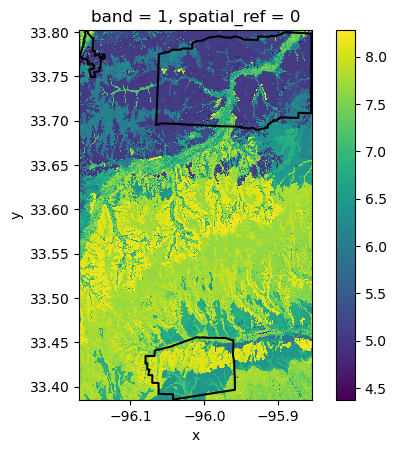

In [6]:
caddo_merged_das.plot()

# Plot Sheyenne National Grasslands on sheyenne_soil_da
caddo_grasslands_gdf.to_crs(caddo_merged_das.rio.crs).boundary.plot(ax = plt.gca(), color='black')

# **BREAK**
### Trying to get one big loop to work for soil data....

In [31]:
# Loop through bounds of Caddo and Sheyenne

# c_s_grasslands_gdf = grasslands_gdf[grasslands_gdf['GRASSLANDN'].isin(['Sheyenne National Grassland', 'Caddo National Grassland'])]
c_s_grasslands_gdf = [caddo_grasslands_gdf, sheyenne_grasslands_gdf]
c_s_grasslands_gdf

bounds = []
soil_urls = []
for gdf in c_s_grasslands_gdf:
    bounds_min_lon, bounds_min_lat, bounds_max_lon, bounds_max_lat = (
    gdf
    #.to_crs(ccrs.UTM(zone=14))
    .total_bounds)
    bounds.append((bounds_min_lon, bounds_min_lat, bounds_max_lon, bounds_max_lat))
    
bounds_df = pd.DataFrame(bounds).rename(
    index={0: 'Caddo Bounds', 1: 'Sheyenne Bounds'},
    columns={0: 'min_lon', 1: 'min_lat', 2: 'max_lon', 3: 'max_lat'})
display(bounds_df)

#  Define the Caddo download URL template for the soil data
soil_url_template = ("http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/"
            "v1.0"
            "/ph"
            "/mean"
            "/60_100"
            "/lat{min_lat}{max_lat}_lon{min_lon}{max_lon}.tif")
display(soil_url_template)

# Maybe turn soil_urls into a dictionary and instead of appending in line 40 add results to dictionary
# Check notebook 92 from redlining code
soil_urls = []
for site_name, site_bounds_df in bounds_df.groupby(level=0):
    print(site_name)
    for min_lon in range(floor(site_bounds_df.min_lon), ceil(site_bounds_df.max_lon)):
        for min_lat in range(floor(site_bounds_df.min_lat), ceil(site_bounds_df.max_lat)):
            print(min_lon, min_lat)
            soil_url = soil_url_template.format(
                min_lat=min_lat, max_lat=min_lat+1,
                min_lon=min_lon, max_lon=min_lon+1)
            soil_urls.append(soil_url)
display(soil_urls)

,min_lon,min_lat,max_lon,max_lat
Caddo Bounds,-96.169235,33.385436,-95.854927,33.801862
Sheyenne Bounds,-97.468810,46.095343,-96.938548,46.572042


'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat{min_lat}{max_lat}_lon{min_lon}{max_lon}.tif'

Caddo Bounds
-97 33
-96 33
Sheyenne Bounds
-98 46
-97 46


C:\Users\riede\AppData\Local\Temp\ipykernel_9256\397394450.py:35: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  for min_lon in range(floor(site_bounds_df.min_lon), ceil(site_bounds_df.max_lon)):
C:\Users\riede\AppData\Local\Temp\ipykernel_9256\397394450.py:36: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  for min_lat in range(floor(site_bounds_df.min_lat), ceil(site_bounds_df.max_lat)):


['http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat3334_lon-97-96.tif',
 'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat3334_lon-96-95.tif',
 'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat4647_lon-98-97.tif',
 'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat4647_lon-97-96.tif']

In [ ]:
# Create a dictionary to store the soil urls
soil_dict = {
    'Caddo1': soil_urls[0],
    'Caddo2': soil_urls[1],
    'Sheyenne1': soil_urls[2],
    'Sheyenne2': soil_urls[3]
}

soil_dict

<built-in method keys of dict object at 0x000001B36A71A3C0>


In [ ]:
list = [1, 2, 3, 4]
dict = {site_name: []}

for i in list:
    new_list = i +10
    dict[site_name].append(new_list)

dict

{'Caddo Bounds': []}

In [ ]:
# Maybe turn soil_urls into a dictionary and instead of appending in line 40 add results to dictionary
# Check notebook 92 from redlining code
soil_urls = []
for site_name, site_bounds_df in bounds_df.groupby(level=0):
    print(site_name)
    for min_lon in range(floor(site_bounds_df.min_lon), ceil(site_bounds_df.max_lon)):
        for min_lat in range(floor(site_bounds_df.min_lat), ceil(site_bounds_df.max_lat)):
            print(min_lon, min_lat)
            soil_url = soil_url_template.format(
                min_lat=min_lat, max_lat=min_lat+1,
                min_lon=min_lon, max_lon=min_lon+1)
            soil_urls.append(soil_url)
display(soil_urls)

Caddo Bounds
-97 33
http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat3334_lon-97-96.tif
-96 33
http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat3334_lon-96-95.tif
Sheyenne Bounds
-98 46
http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat4647_lon-98-97.tif
-97 46
http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat4647_lon-97-96.tif


C:\Users\riede\AppData\Local\Temp\ipykernel_9256\2896861671.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  for min_lon in range(floor(site_bounds_df.min_lon), ceil(site_bounds_df.max_lon)):
C:\Users\riede\AppData\Local\Temp\ipykernel_9256\2896861671.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  for min_lat in range(floor(site_bounds_df.min_lat), ceil(site_bounds_df.max_lat)):


{'Sheyenne Bounds': []}

In [8]:
cropped_das = []
# Loop through each of the soil files
for url in soil_urls:
    # Download raster data

    # Unzip the raster data

    # Extract metadata from the file name

    # Only download once -- Save raster data to the disk

    # Load the raster data into Python, mask and scale and squeeze w/ .tif files
    soil_da = rxr.open_rasterio(
        url,
        mask_and_scale=True
        ).squeeze()
    print('OPENED')
    # sheyenne_das.append(soil_da)
    # Make sure that the CRS matches between the vector and raster data, this could also be done up above the output_da_list is defined
    
    # Crop the raster data
    cropped_da = soil_da.rio.clip_box(*caddo_bounds)
    caddo_das.append(cropped_da)
    print('CROPPED')

display(cropped_das)

OPENED
CROPPED
OPENED
CROPPED
OPENED


NoDataInBounds: No data found in bounds.

# **BREAK**

In [8]:
bounds

[(np.float64(-96.1692345765796),
  np.float64(33.38543577462093),
  np.float64(-95.85492673757102),
  np.float64(33.80186198772292)),
 (np.float64(-97.46881033436894),
  np.float64(46.0953431579286),
  np.float64(-96.93854828332353),
  np.float64(46.57204154162918))]

In [9]:
for i in bounds:
    print(i)

(np.float64(-96.1692345765796), np.float64(33.38543577462093), np.float64(-95.85492673757102), np.float64(33.80186198772292))
(np.float64(-97.46881033436894), np.float64(46.0953431579286), np.float64(-96.93854828332353), np.float64(46.57204154162918))


In [10]:
keys = ['Caddo1', 'Caddo2', 'Sheyenne1', 'Sheyenne2']

output = {}
for key, value in zip(keys, soil_urls):
    output[key] = value

output

{'Caddo1': 'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat3334_lon-97-96.tif',
 'Caddo2': 'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat3334_lon-96-95.tif',
 'Sheyenne1': 'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat4647_lon-98-97.tif',
 'Sheyenne2': 'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat4647_lon-97-96.tif'}

In [11]:
bounds

[(np.float64(-96.1692345765796),
  np.float64(33.38543577462093),
  np.float64(-95.85492673757102),
  np.float64(33.80186198772292)),
 (np.float64(-97.46881033436894),
  np.float64(46.0953431579286),
  np.float64(-96.93854828332353),
  np.float64(46.57204154162918))]

In [12]:
all_soil_das = []
# Loop through each of the soil files
for url in soil_urls:
    print(url)
    # Download raster data

    # Unzip the raster data

    # Extract metadata from the file name

    # Only download once -- Save raster data to the disk

    # Load the raster data into Python, mask and scale and squeeze w/ .tif files
    soil_da = rxr.open_rasterio(
        url,
        mask_and_scale=True
        ).squeeze()
    print('OPENED')
    # sheyenne_das.append(soil_da)
    # Make sure that the CRS matches between the vector and raster data, this could also be done up above the output_da_list is defined

# Crop the raster data
for bounds in bounds:
    print(bounds)
    # cropped_da = soil_da.rio.clip_box(*caddo_bounds)
    # all_soil_das.append(cropped_da)
    # print('CROPPED')

# caddo_bounds is a data array
# caddo_bounds = c_bounds_min_lon, c_bounds_min_lat, c_bounds_max_lon, c_bounds_max_lat = (
#     caddo_grasslands_gdf
#     #.to_crs(ccrs.UTM(zone=14))
#     .total_bounds)
# display(caddo_bounds)

http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat3334_lon-97-96.tif


OPENED
http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat3334_lon-96-95.tif
OPENED
http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat4647_lon-98-97.tif
OPENED
http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat4647_lon-97-96.tif
OPENED
(np.float64(-96.1692345765796), np.float64(33.38543577462093), np.float64(-95.85492673757102), np.float64(33.80186198772292))
(np.float64(-97.46881033436894), np.float64(46.0953431579286), np.float64(-96.93854828332353), np.float64(46.57204154162918))


In [13]:
soil_url_dict = {
    'Caddo Soil URL':,
    'Sheyenne Soil URL:'
}

test_dict = {band_name: [] for band_name in bands.keys()}
test_dict

SyntaxError: expression expected after dictionary key and ':' (2662134095.py, line 2)

In [ ]:
test_dict[band_name]

In [ ]:
# Loop through bounds of Caddo and Sheyenne

# c_s_grasslands_gdf = grasslands_gdf[grasslands_gdf['GRASSLANDN'].isin(['Sheyenne National Grassland', 'Caddo National Grassland'])]
c_s_grasslands_gdf = [caddo_grasslands_gdf, sheyenne_grasslands_gdf]
c_s_grasslands_gdf

bounds = []
for gdf in c_s_grasslands_gdf:
    bounds_min_lon, bounds_min_lat, bounds_max_lon, bounds_max_lat = (
    gdf
    #.to_crs(ccrs.UTM(zone=14))
    .total_bounds)
    bounds.append((bounds_min_lon, bounds_min_lat, bounds_max_lon, bounds_max_lat))

bounds_df = pd.DataFrame(bounds).rename(
    index={0: 'Caddo Bounds', 1: 'Sheyenne Bounds'},
    columns={0: 'min_lon', 1: 'min_lat', 2: 'max_lon', 3: 'max_lat'})

bounds_df
    

#  Define the Caddo download URL template for the soil data
soil_url_template = ("http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/"
            "v1.0"
            "/ph"
            "/mean"
            "/60_100"
            "/lat{min_lat}{max_lat}_lon{min_lon}{max_lon}.tif")
display(soil_url_template)

soil_urls = []
for row in bounds_df.groupby(level=0):
    for min_lon in range(floor(bounds_min_lon), ceil(bounds_max_lon)):
         print(min_lon)
         for min_lat in range(floor(bounds_min_lat), ceil(bounds_max_lat)):
             print(min_lat)
    #         soil_url = soil_url_template.format(
    #             min_lat=min_lat, max_lat=min_lat+1,
    #             min_lon=min_lon, max_lon=min_lon+1)
    #         soil_urls.append(soil_url)
    #display(soil_urls)
# display(bounds)
# display(bounds_df)
soil_urls



# List out all the Caddo soil files we will need to download
# caddo_soil_url_list = []
# for min_lon in range(floor(c_bounds_min_lon), ceil(c_bounds_max_lon)):
#     for min_lat in range(floor(c_bounds_min_lat), ceil(c_bounds_max_lat)):
#         soil_url = caddo_soil_template_url.format(
#             min_lon=min_lon, max_lon=min_lon+1)
#         caddo_soil_url_list.append(soil_url)
# display(caddo_soil_url_list)

'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat{min_lat}{max_lat}_lon{min_lon}{max_lon}.tif'

-98
46
-97
46
-98
46
-97
46


[]